In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json

import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

from fuzzywuzzy import process


# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "correct_return_periods.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths, get_logo_path, get_data_paths, setup_root_paths
setup_project_paths(PATH)

from utils_cumulative_distribution import calculate_cumulative_distribution

#from utils_plotting import plot_time_series, plot_random_monthly_and_yearly_data, plot_feature_histograms, plot_contry_period_map
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
from utils_cumulative_distribution import calculate_cumulative_distribution
from utils_likelihoods import calculate_likelihood_of_at_least_one_event

from utils_return_periods import calculate_return_periods

#from utils_global_probabilities import calculate_global_probabilities
#from utils_country_probabilities import calculate_all_country_probabilities
#from utils_check_expected_features import check_expected_features    
#from utils_date_index import calculate_date_from_index 
#from utils_country_id_csv_to_json import country_id_csv_to_json
#from utils_get_country_names_by_ids import get_country_names_by_ids
#from utils_get_country_id_by_name import get_country_id_by_name

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


In [3]:
PATH_RAW_VIEWSER, PATH_RAW_EXTERNAL, PATH_PROCESSED, PATH_GENERATED = get_data_paths(PATH)

In [4]:
# # load the data from pkl
# df_monthly = pd.read_pickle(PATH_RAW_VIEWSER / "simon_full_base_01_viewser_df.pkl")
# 
# df_yearly = aggregate_monthly_to_yearly(df_monthly)
# 
# # Feature engineering
# df_monthly = feature_eng_fat_per_100k(df_monthly)
# df_yearly = feature_eng_fat_per_100k(df_yearly)
# 
# # save the data
# df_monthly.to_pickle(PATH_PROCESSED / "df_monthly_new.pkl")  
# df_yearly.to_pickle(PATH_PROCESSED / "df_yearly_new.pkl")

In [5]:
# load the data
df_monthly = pd.read_pickle(PATH_PROCESSED / "df_monthly_new.pkl")
df_yearly = pd.read_pickle(PATH_PROCESSED / "df_yearly_new.pkl")

In [6]:
df_monthly.columns

Index(['month_id', 'pg_id', 'month', 'year_id', 'c_id', 'col', 'row',
       'sb_best', 'ns_best', 'os_best', 'pop_gpw_sum', 'total_best',
       'fatalities_per_100k', 'sb_per_100k', 'ns_per_100k', 'os_per_100k'],
      dtype='object')

In [7]:
cdf = calculate_cumulative_distribution(df_monthly, 'fatalities_per_100k')

In [8]:
cdf

fatalities_per_100k
2651.971082    3.632269e-07
1705.396679    5.448404e-07
1635.390779    7.264538e-07
1566.345247    9.080673e-07
1111.867218    1.089681e-06
                   ...     
0.009619       8.204206e-03
0.009467       8.204388e-03
0.008606       8.204569e-03
0.008054       8.208202e-03
0.000000       1.000000e+00
Name: count, Length: 17231, dtype: float64

In [18]:
liklihood = calculate_likelihood_of_at_least_one_event(cdf, 100000)  

In [19]:
return_periods = calculate_return_periods(liklihood, 'cdf', 'likelihood')

In [20]:
return_periods

,cdf,likelihood,cdf_return_period,at_least_one_occurrence_return_period
fatalities_per_100k,,,,
2651.971082,3.632269e-07,0.035671,2.753100e+06,28.034022
1705.396679,5.448404e-07,0.053026,1.835400e+06,18.858535
1635.390779,7.264538e-07,0.070069,1.376550e+06,14.271548
1566.345247,9.080673e-07,0.086806,1.101240e+06,11.519961
1111.867218,1.089681e-06,0.103241,9.177000e+05,9.686074
...,...,...,...,...
0.009619,8.204206e-03,1.000000,1.218887e+02,1.000000
0.009467,8.204388e-03,1.000000,1.218860e+02,1.000000
0.008606,8.204569e-03,1.000000,1.218833e+02,1.000000


In [12]:
liklihood['cdf']

fatalities_per_100k
2651.971082    3.632269e-07
1705.396679    5.448404e-07
1635.390779    7.264538e-07
1566.345247    9.080673e-07
1111.867218    1.089681e-06
                   ...     
0.009619       8.204206e-03
0.009467       8.204388e-03
0.008606       8.204569e-03
0.008054       8.208202e-03
0.000000       1.000000e+00
Name: cdf, Length: 17231, dtype: float64

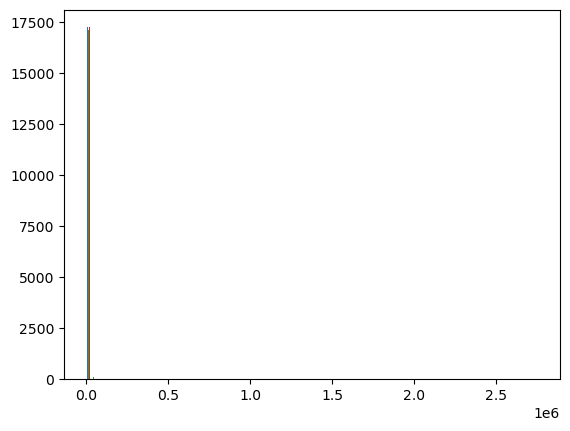

In [13]:
plt.hist(liklihood, bins=100)
plt.show()

In [14]:
return_periods = calculate_return_periods(cdf, liklihood, 10000)

TypeError: Indexing a Series with DataFrame is not supported, use the appropriate DataFrame column